Dennis Wang

Dataset from https://www.kaggle.com/datasets/samuelotiattakorah/healthcare-no-show-appointment-data

Background on Data:
Information on 100k+ medical appointments from various neighborhoods in Brazil, with the goal of predicting whether or not a patient would show up to their appointment. 


## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/healthcare_noshows_appointments.csv", dtype={'PatientId': str, 'AppointmentID': str})
#df['PatientId'] = df['PatientId'].astype(int).astype(str)
display(df.head())
display(df.shape)
display(df.info())


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


(106987, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientId       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hipertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handcap         106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  Showed_up       106987 non-null  bool  
 14  Date.diff       106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


None

Columns names are inconsistent --> Renaming them for ease

In [3]:
df = df.rename(columns={"PatientId": "PatientID", "Showed_up": "ShowedUp", "Date.diff": "DateDiff","Hipertension":"Hypertension", "Handcap":"Handicap"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientID       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hypertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handicap        106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  ShowedUp        106987 non-null  bool  
 14  DateDiff        106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


It seems a lot of our columns are binary. 

We know each row represents each appointment, but we also need to check if there are patients that occur more than one. If that's the case, then the data isn't iid.

In [4]:
display(len(df['PatientID'].unique()))
display(len(df['AppointmentID'].unique()))

60270

106987

Since some patients appear more than once in the dataset, we will have to stratify by patient when splitting later on.

We'll drop column 'AppointmentID' because we don't need the unique appointment identifier.

In [5]:
df = df.drop(['AppointmentID'], axis=1)

Reordering our columns because I want the target variable 'ShowedUp' to be last, and also for 'DateDiff' to be right after the 'ScheduledDay' and 'AppointmentDay' columns. 'DateDiff' is the number of days between 'ScheduledDay' and 'AppointmentDay' so it makes sense to have them together.

And then creating our X and y variables.

In [6]:
df = df[['PatientID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'DateDiff', 'Age',
       'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received','ShowedUp']]
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

#### Visualizing the Target Variable

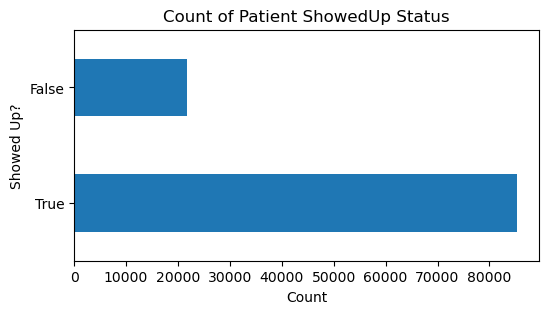

In [7]:
plt.figure(figsize=(6,3))
df['ShowedUp'].value_counts().plot.barh()
plt.xlabel('Count')
plt.ylabel('Showed Up?')
plt.title('Count of Patient ShowedUp Status')
plt.show()

Looks like our categorical target variable, ShowedUp, is highly imbalanced. Thankfully most people show up to their appointment, but we'll have to make sure to stratify when splitting into our train, validation, and test sets later on.

Let's check out our variable DateDiff:

In [8]:
display(df['DateDiff'][df['ShowedUp'] == 1].describe())
(df['DateDiff'][df['ShowedUp'] == 0].describe())

count    85307.000000
mean         8.737794
std         14.558336
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        179.000000
Name: DateDiff, dtype: float64

count    21680.000000
mean        15.789299
std         16.615843
min         -6.000000
25%          4.000000
50%         10.500000
75%         23.000000
max        179.000000
Name: DateDiff, dtype: float64

DateDiff is very imbalanced. Let's visualize it against ShowedUp status:

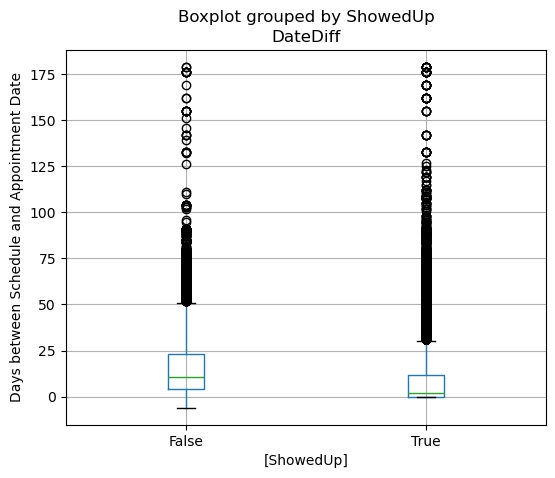

In [9]:
df[['DateDiff','ShowedUp']].boxplot(by='ShowedUp',figsize=(6,5))
plt.ylabel('Days between Schedule and Appointment Date')
plt.show()

A lot of DateDiff outliers regardless of no-show status. We'll probably have to preprocess DateDiff using StandardScaler later on.

Interestingly, we can see that the minimum DateDiff in the false 'ShowedUp' boxplot is actually negative. Maybe it was a clerical error? Or an appointment that was scheduled retroactively for bookkeeping purposes? 

I want to see how the proportion of No Shows changes with increasing DateDiff.

In [10]:
df2 = df[df['ShowedUp'] == False].groupby("DateDiff").count().reset_index()[['DateDiff', 'ShowedUp']].rename(columns = {"DateDiff":"DateDiff", "ShowedUp":"No Shows"}).set_index(['DateDiff'])
df3 = df.groupby("DateDiff").count().reset_index()[['DateDiff', 'ShowedUp']].rename(columns = {"DateDiff":"DateDiff", "ShowedUp":"TotalCount"}).set_index(['DateDiff'])

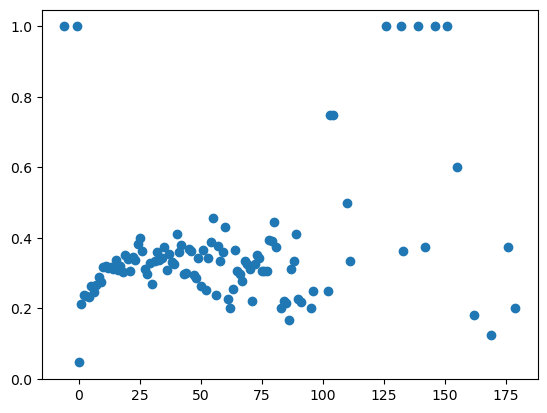

In [11]:
#pd.concat([df2, df3], axis=1)
df23 = df2.merge(df3, on='DateDiff', how='outer')
df23['NoShow_Prop'] = df23['No Shows'] / df23['TotalCount']
df23 = df23.reset_index()

plt.scatter(df23['DateDiff'], df23['NoShow_Prop'])


It does seem that there's an initial strong correlation that as the DateDiff increases, so does the proportion of No Shows. However, after ~30 days, this correlation weakens considerably and instead the variance of No Show Proportion increases dramatically.

Another explanatory variable of interest is 'SMS_received', which indicates whether or not a patient was sent one or more ahead of their appointment to remind them of it. We visualize it against our target variable below:

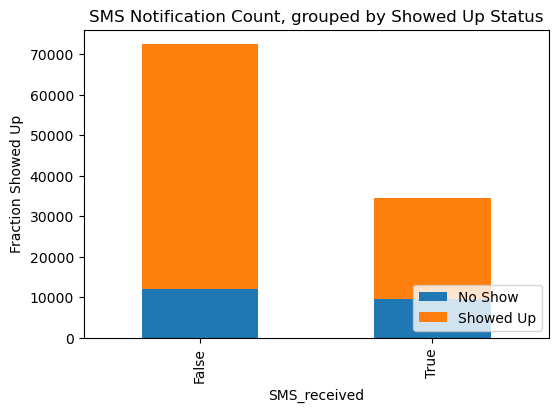

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
p = df.groupby(['SMS_received', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.ylabel('Fraction Showed Up')
plt.legend(["No Show", "Showed Up"],loc=4)
plt.title("SMS Notification Count, grouped by Showed Up Status")
plt.show()

Interestingly, the vast majority of the patients in the dataset (approximately two-thirds it seems) don't receive any sort of notification reminder ahead of their appointment. Perhaps increased this number, we would see a reduction in no-shows? Let's try visualizing the SMS_received vs. ShowedUp again, but normalized this time:

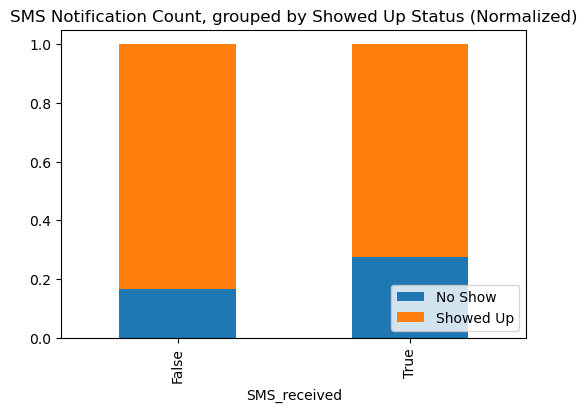

In [13]:

count_matrix = df.groupby(['SMS_received', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(6,4))
plt.title("SMS Notification Count, grouped by Showed Up Status (Normalized)")
plt.legend(["No Show", "Showed Up"],loc=4)
plt.show()

Surprisingly, and against my earlier belief, it seems that the group of patients that received an SMS ahead of their appointment actually have higher no-show rates, at least in this dataset.

Let's visualize Gender vs. ShowedUp:

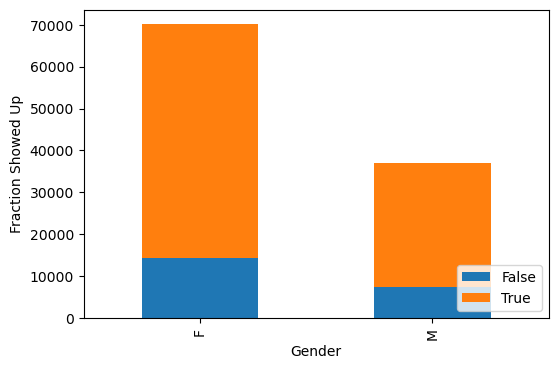

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
p = df.groupby(['Gender', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.ylabel('Fraction Showed Up')
plt.legend(loc=4)
plt.show()


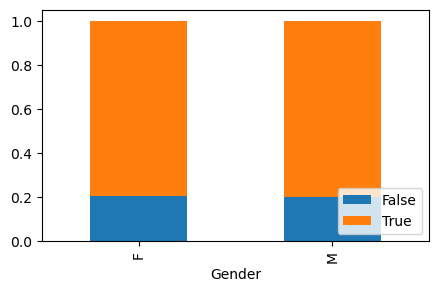

In [15]:
count_matrix = df.groupby(['Gender', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.legend(loc=4)

There are twice as many Females as Males in our dataset, but after normalization, their No Show rates are approximately the same, so I don't anticipate Gender to be a strong predictor in our model.

How about neighborhood though? There are approximately 80 unique neighborhoods in our dataset, so let's just normalize the top 10.

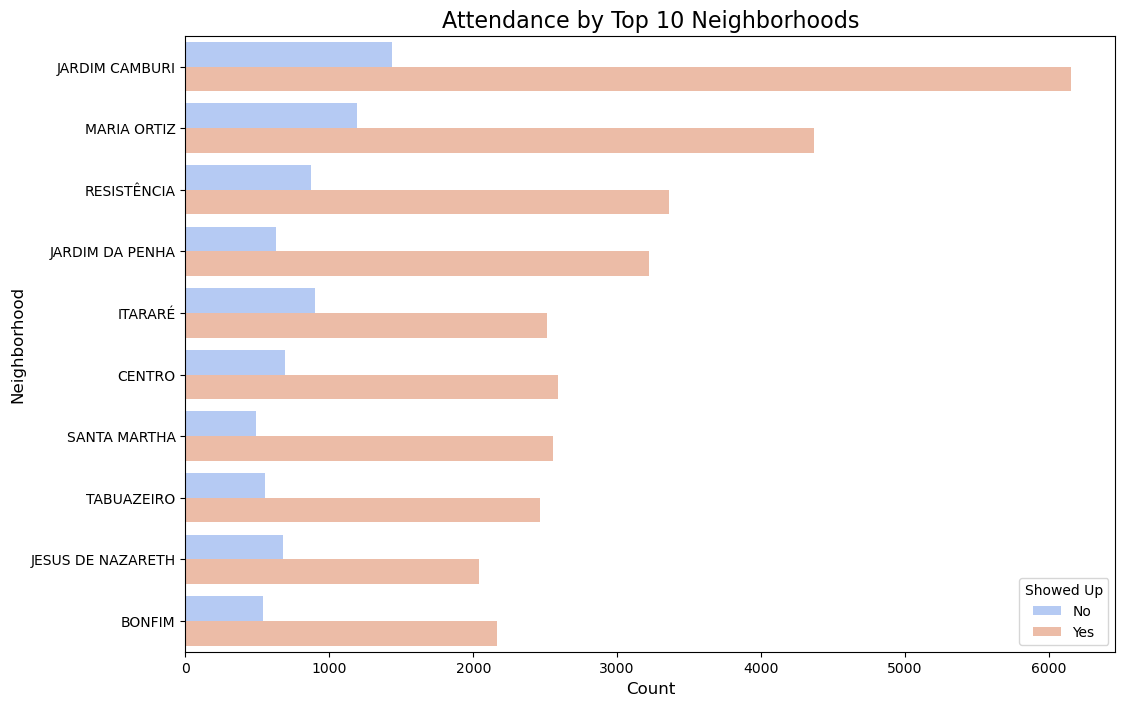

In [39]:
import seaborn as sns
top_neighborhoods = df['Neighbourhood'].value_counts().nlargest(10).index
neighborhood_data = df[df['Neighbourhood'].isin(top_neighborhoods)]

plt.figure(figsize=(12, 8))
sns.countplot(
    y='Neighbourhood',
    hue='ShowedUp',
    data=neighborhood_data,
    order=top_neighborhoods,
    palette='coolwarm'
)
plt.title('Attendance by Top 10 Neighborhoods', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.legend(title='Showed Up', labels=['No', 'Yes'], fontsize=10)
plt.show()

Looks like there's definitely more representation from some neighbourhoods compared to others, such as Jardim Camburi, Maria Ortiz, and Resistencia. But are any of these actually correlated with our target variable? Let's try normalizing the plot:

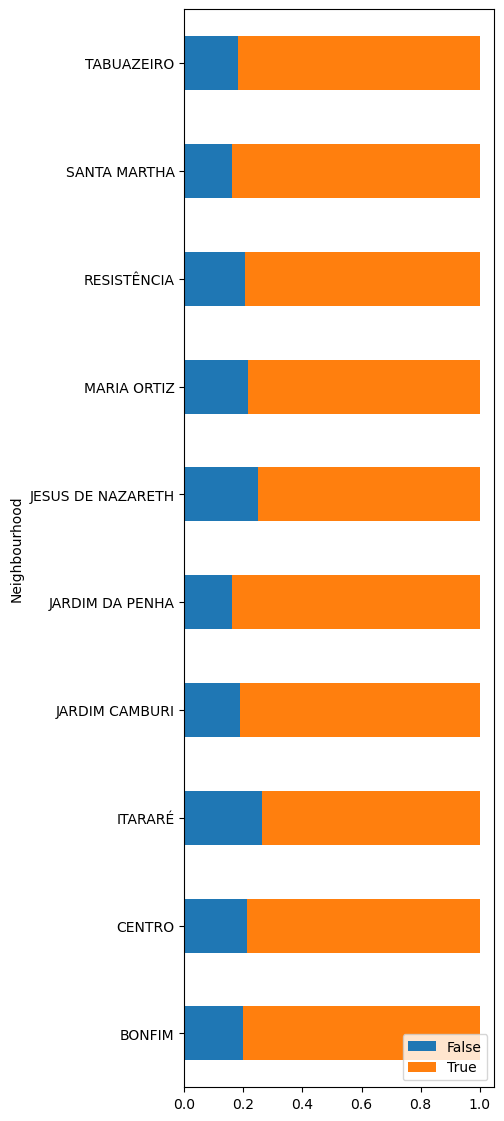

In [42]:
count_matrix = neighborhood_data.groupby(['Neighbourhood', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='barh', stacked=True,figsize=(4,14))
plt.legend(loc=4)

The normalized plot seems fairly uniform in ShowedUp status proportion. I don't anticipate the Neighborhoods to be a strong predictor in our model.

In [19]:
df.loc[:, df.isnull().any() ]

""
0
1
2
3
4
...
106982
106983
106984
106985


No missing values in our dataset.

#### Testing relationships between our features and target variable

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
df_num = df[['Age','Scholarship','Hypertension','Diabetes','Alcoholism','Handicap','SMS_received', 'DateDiff', 'ShowedUp']]

pearson_corr = df_num.corr(method='pearson')
pearson_corr.style.background_gradient(cmap='coolwarm')


,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,DateDiff,ShowedUp
Age,1.000000,-0.112699,0.502091,0.290631,0.090391,0.079726,0.005251,0.038880,0.067025
Scholarship,-0.112699,1.000000,-0.024530,-0.027622,0.033527,-0.010465,-0.000010,-0.030439,-0.029370
Hypertension,0.502091,-0.024530,1.000000,0.430827,0.085459,0.082909,-0.008805,-0.016996,0.037280
Diabetes,0.290631,-0.027622,0.430827,1.000000,0.016874,0.057945,-0.016136,-0.027339,0.015928
Alcoholism,0.090391,0.033527,0.085459,0.016874,1.000000,0.002864,-0.027403,-0.038949,0.000517
Handicap,0.079726,-0.010465,0.082909,0.057945,0.002864,1.000000,-0.026256,-0.021101,0.007620
SMS_received,0.005251,-0.000010,-0.008805,-0.016136,-0.027403,-0.026256,1.000000,0.396482,-0.127253
DateDiff,0.038880,-0.030439,-0.016996,-0.027339,-0.038949,-0.021101,0.396482,1.000000,-0.185704
ShowedUp,0.067025,-0.029370,0.037280,0.015928,0.000517,0.007620,-0.127253,-0.185704,1.000000


Not that much correlation between our numerical features. Between our explanatory features and target variable, the strongest relationship lies between DateDiff and ShowedUp. Between strictly our explanatory features, we can see that Hypertension is somewhat correlated with Age and Diabetes.

How about linear correlations between our features and the target variable?

Text(0, 0.5, 'F-statistic')

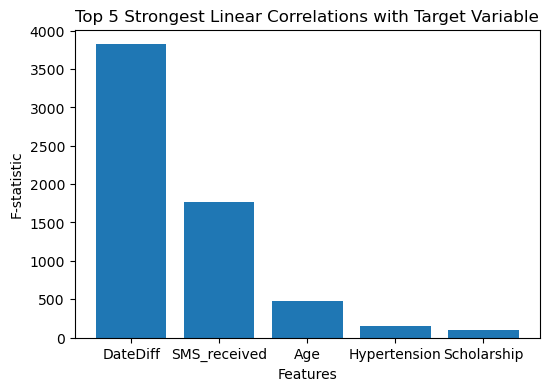

In [21]:
from sklearn.feature_selection import f_regression

X_nums = df_num.drop(['ShowedUp'], axis=1)
Y_nums = np.ravel(df_num.iloc[:,-1:])

f_statistic, p_values = f_regression(X_nums, Y_nums)

cols = X_nums.columns
f_df = pd.DataFrame(data = f_statistic, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=f_df.index, height = f_df[0])
plt.title('Top 5 Strongest Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('F-statistic')


How about non-linear correlations? i.e. mutual information

Text(0, 0.5, 'Estimated Mutual Information')

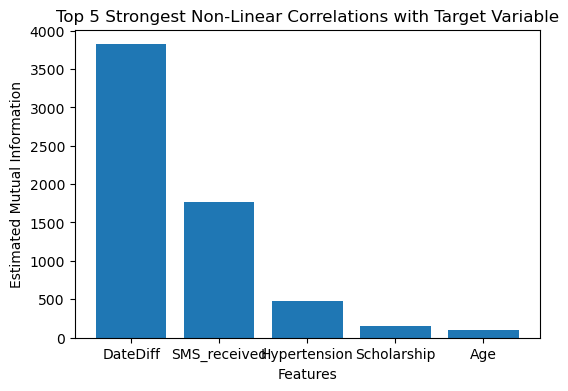

In [22]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X_nums, Y_nums)

cols = X_nums.columns
mi_df = pd.DataFrame(data = mi, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=mi_df.index, height = f_df[0])
plt.title('Top 5 Strongest Non-Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('Estimated Mutual Information')

Both plots look similar, with DateDiff and SMS_received being our features most correlated with the target variable, ShowedUp. This aligns with our pearson correlation plot.

#### Converting Gender Strings 'M' and 'F' to 0 and 1

In [23]:
df = df.replace({'Gender':{'M':1, 'F':0}})

C:\Users\DWang\AppData\Local\Temp\ipykernel_27128\882688251.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Gender':{'M':1, 'F':0}})


#### Feature Engineer Day of Week columns + month columns from ScheduledDay and AppointmentDay
Since some of our patients occur more than once in our dataset, their column information would be pretty much identical between appointments, save for the ScheduledDay, AppointmentDay, and DateDiff columns. Feature engineering some new variables from ScheduledDay and AppointmentDay could be another way to further differentiate those rows.

In [24]:
df['ApptDayOfWeek'] = pd.to_datetime(df['AppointmentDay']).dt.day_name()
df['ApptMonth'] = pd.to_datetime(df['AppointmentDay']).dt.month_name()

df['SchedDayOfWeek'] = pd.to_datetime(df['ScheduledDay']).dt.day_name()
df['SchedMonth'] = pd.to_datetime(df['ScheduledDay']).dt.month_name()

Let's visualize our 4 new columns:

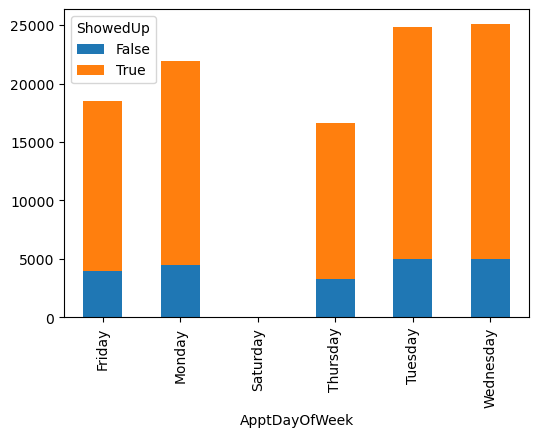

In [25]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['ApptDayOfWeek', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

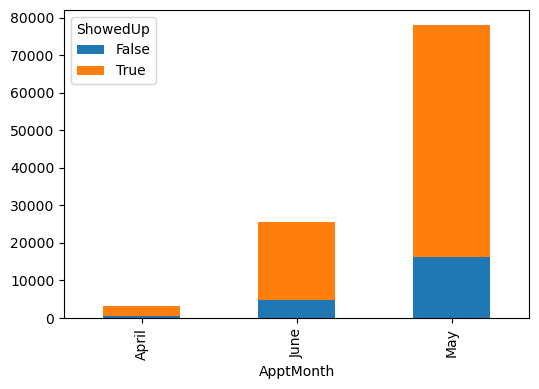

In [26]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['ApptMonth', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

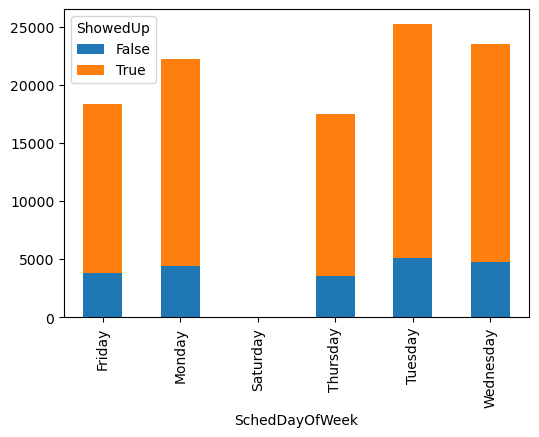

In [27]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['SchedDayOfWeek', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

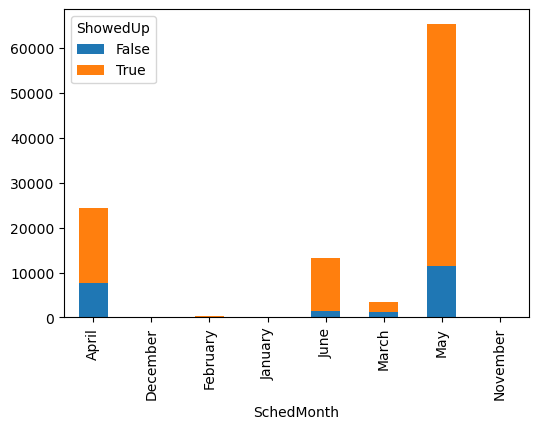

In [28]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['SchedMonth', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

In [29]:
np.unique(df['SchedMonth'])

array(['April', 'December', 'February', 'January', 'June', 'March', 'May',
       'November'], dtype=object)

Interesting that the vast majority of Appointments are both scheduled during and for the Spring months. There are definitely values for other months of the year, but they barely appear in the plots.

### Splitting Data

> Describe briefly how you split the data and why.

We have two main concerns to address in our splitting strategy:
1. making sure patients stay within their splits, i.e. preventing data leakage via grouping.
2. making sure our imbalanced target variable is properly distributed across our splits, i.e. stratifying

Therefore we'll use two rounds of StratifiedGroupKFold:
1. 1st split to split into X_other and X_test
2. 2nd split to split into X_train and X_val

Given we have ~100k rows, we'll use n_splits = 5 to have 4 folds for X_other, and 1 fold for X_test (4:1) This means X_other will have approximately 80k rows and X_test will have 20k rows. We'll further split X_other using n_splits = 4 (3:1) so that X_train will have roughly 60k rows and X_val will have roughly 20k rows. As a result, we'll achieve our 60:20:20 train:validation:test size ratio.

We will be creating our test set for evaluating how our model performs on previously unseen data later. We will have to repeat the data under the second round of splitting again for when we're training our models and cross-validating them. But, for now we'll leave it in here to prove that this splitting strategy achieves our goals:

In [92]:
from sklearn.model_selection import StratifiedGroupKFold
random_state = 1030
# Dropping these columns since we can't use them in our model.
X = df.drop(['ShowedUp', 'ScheduledDay', 'AppointmentDay'], axis=1)
y = df['ShowedUp']
groups = df['PatientID']

sgkf = StratifiedGroupKFold(n_splits=5, random_state=1030, shuffle=True)

# 1st split - split train+val and test sets
for trainval_index, test_index in sgkf.split(X, y, groups=groups):
    X_trainval, X_test = X.iloc[trainval_index], X.iloc[test_index]
    y_trainval, y_test = y.iloc[trainval_index], y.iloc[test_index]
    groups_trainval = groups.iloc[trainval_index]

# Will have to repeat this part when training our models
sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=1030, shuffle=True)
# 2nd split - splitting trainval into training and validation sets
for train_index, val_index in sgkf_2.split(X_trainval, y_trainval, groups = groups_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

Let's show that our splitting strategy worked so that we've achieved:
1. Roughly 60:20:20 train:val:test sizes
2. Stratification preserves class imbalances across datasets
3. No data leakage regarding PatientId groups

In [82]:
for key, value in {"X":X, "X_train":X_train, "X_val": X_val, "X_test":X_test}.items():
    print(f'{key} rows: \t{value.shape[0]}')
print("Splits are roughly 60:20:20 sizes")

X rows: 	106987
X_train rows: 	63853
X_val rows: 	21810
X_test rows: 	21324
Splits are roughly 60:20:20 sizes


In [ ]:
def getProp(df):
    num = df[df == False].count()
    denom = df.count()
    return num / denom
print(f"No Show Status proportion\n{getProp(y_train)}\n{getProp(y_val)}\n{getProp(y_test)}")

No Show Status proportion
0.20332639030272656
0.20829894543787253
0.19480397673982366


In [83]:
a = X_train['PatientID']
b = X_val['PatientID']
c = X_test['PatientID']
print(list(set(a) & set(b) & set(c)))
print("No overlap in PatientID between groups")

[]
No overlap in PatientID between groups


In [89]:
X_val.columns

Index(['PatientID', 'Gender', 'DateDiff', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap',
       'SMS_received', 'ApptDayOfWeek', 'ApptMonth', 'SchedDayOfWeek',
       'SchedMonth'],
      dtype='object')

In [93]:
# Dropping PatientID in all of our sets now that we don't need it anymore:
pd.options.mode.chained_assignment = None  # default='warn'
drop_patid = lambda xset: xset.drop("PatientID", axis = 1, inplace = True)
for i in [X_train, X_val, X_test]: drop_patid(i)

### Preprocessing the Data

>What preprocessors did you use and why? 
>
>How many features and data points do you have before and after preprocessing. 
>
>If you have missing values, describe the basic properties of the missing values (e.g., what fraction of the points have missing values, which features, what fraction of the features are missing, etc).

#### Use a Pipeline for the following:
- normalize Age (MinMax Scaler)
- standardize DateDiff (StandardScaler)
- one hot encode neighbourhood (81 unique values)
- one hot encode:
    - ApptDayOfWeek
    - SchedDayOfWeek
    - ApptMonth
    - SchedMonth

Minmax scale age since the range of values that an age could possibly take are fairly predictable. The same cannot be said for DateDiff (given all the outliers in our boxplot), so I'm applying StandardScaler to that.

I will one hot encode neighborhood which has 81 different and unique neighborhoods. This will create a lot of columns.

I thought about ordinal encoding our DaysOfWeek or Month columns but there really isn't a "ranking" to days in a week or months other than the order they come in. One isn't inherently "less" than another. Instead, I will also one hot encode these columns.

In [95]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn import set_config
"""
ordinal_ftrs = ['ApptDayOfWeek', 'SchedDayOfWeek', 'ApptMonth', 'SchedMonth'] 
# sunday doesn't show up in DayOfWeek columns
ordinal_cats = [['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],\
                ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],\
                ['January', 'February', 'March', 'April', 'May', 'June', 'July' ,'August', 'September', 'October', 'November', 'December'],\
                ['January', 'February', 'March', 'April', 'May', 'June', 'July' ,'August', 'September', 'October', 'November', 'December']]
"""
onehot_ftrs = ['Neighbourhood', 'ApptDayOfWeek', 'SchedDayOfWeek', 'ApptMonth', 'SchedMonth']
minmax_ftrs = ['Age']
std_ftrs = ['DateDiff']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        #('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)]
        , remainder = 'passthrough')
set_config(transform_output="pandas")
prep = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = prep.fit_transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)

print(X_train.shape)
print(X_train_prep.shape)
#print(X_train_prep)
print(X_val.shape)
print(X_val_prep.shape)
print(X_test.shape)
print(X_test_prep.shape)


(63853, 14)
(63853, 112)
(21810, 14)
(21810, 112)
(21324, 14)
(21324, 112)


Check the results of our Preprocessing

In [33]:
[i for i in X_train_prep.columns]

['onehot__Neighbourhood_AEROPORTO',
 'onehot__Neighbourhood_ANDORINHAS',
 'onehot__Neighbourhood_ANTÔNIO HONÓRIO',
 'onehot__Neighbourhood_ARIOVALDO FAVALESSA',
 'onehot__Neighbourhood_BARRO VERMELHO',
 'onehot__Neighbourhood_BELA VISTA',
 'onehot__Neighbourhood_BENTO FERREIRA',
 'onehot__Neighbourhood_BOA VISTA',
 'onehot__Neighbourhood_BONFIM',
 'onehot__Neighbourhood_CARATOÍRA',
 'onehot__Neighbourhood_CENTRO',
 'onehot__Neighbourhood_COMDUSA',
 'onehot__Neighbourhood_CONQUISTA',
 'onehot__Neighbourhood_CONSOLAÇÃO',
 'onehot__Neighbourhood_CRUZAMENTO',
 'onehot__Neighbourhood_DA PENHA',
 'onehot__Neighbourhood_DE LOURDES',
 'onehot__Neighbourhood_DO CABRAL',
 'onehot__Neighbourhood_DO MOSCOSO',
 'onehot__Neighbourhood_DO QUADRO',
 'onehot__Neighbourhood_ENSEADA DO SUÁ',
 'onehot__Neighbourhood_ESTRELINHA',
 'onehot__Neighbourhood_FONTE GRANDE',
 'onehot__Neighbourhood_FORTE SÃO JOÃO',
 'onehot__Neighbourhood_FRADINHOS',
 'onehot__Neighbourhood_GOIABEIRAS',
 'onehot__Neighbourhood_GR

In [34]:
print(X_train['DateDiff'].describe())
print('\n')
print(X_train_prep['std__DateDiff'].describe())

count    63853.000000
mean        10.157174
std         15.222133
min         -1.000000
25%          0.000000
50%          4.000000
75%         15.000000
max        179.000000
Name: DateDiff, dtype: float64


count    6.385300e+04
mean    -4.451116e-17
std      1.000008e+00
min     -7.329630e-01
25%     -6.672687e-01
50%     -4.044914e-01
75%      3.181462e-01
max      1.109202e+01
Name: std__DateDiff, dtype: float64


### Evaluation Metric:

We will need to consider the baseline, which is the result of predicting the majority  (True of ShowedUp status) for every point.

In [35]:
len(y_test[y_test == True]) / len(y_test)

0.8051960232601764

The baseline accuracy is 80.5%. Since the dataset is heavily imbalanced, we can consider the following metrics that don't use the True Negative Rate:
- average_precision_score
- f score (beta = 1)
- precision-recall curve
- logloss

Do we prioritize minimizing FP's or FN's? The "cost" of predicting wrong is not particularly huge, so we can just stick with beta = 1 for our F-score.

### Choosing our Machine Learning Algorithm

 Try at least four different ML algorithms we covered in class1 on your dataset and at least two of those models should be non-linear. Describe what parameters you tune and the values you try.

 Measure the uncertainties of your evaluation metric due to splitting and due to non-deterministic ML methods (e.g., random forest). In general, explain what considerations went into each step of the pipeline

- Logistic Regression
- KNN (no weight_class)
- XGBoost
- Random Forest
- SVC

In [101]:
np.logspace(-4,2,num=4)

array([1.e-04, 1.e-02, 1.e+00, 1.e+02])

In [ ]:
#TODO: look at hyperparameter tuning.ipynb for how to do GridSearchCV with kfold cv
#TODO: Get scores per model and per random state
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# look at gridsearchcv and ps7
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

for i in range(nr_states):
    sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=i, shuffle=True)
    # 2nd split - splitting trainval into training and validation sets
    model_list = []
    #for train_index, val_index in sgkf_2.split(X_trainval, y_trainval, groups = groups_trainval):
    #    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    #    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

    # initialize lists of our ML models
    models = [
        LogisticRegression(random_state=42*i),
        KNeighborsClassifier(random_state=43*i),
        XGBClassifier(random_state=44*i),
        RandomForestClassifier(random_state=45*i),
        SVC(random_state=46*i)
    ]
    # and our lists of parameters, GridSearchCV will loop through all combos
    param_list = [
        { #LogisticRegression
            'model__penalty': ['l1','l2','elasticnet',None],
            'model__C':1/np.logspace(-1,6,32), #inverse of alpha
            'model__class_weight':[None,'balanced']
        },
        { #KNN
            'model__n_neighbors': [1, 3, 5, 10, 20, 30],
            'model__weights': ['uniform','distance',None]
        },
        { #XGBoost
            'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
            'model__n_estimators': [10000],
            'model__max_depth': [1, 3, 5, 10, 30, 100],
            'model__subsample': [0.7, 0.8, 0.9],
            'model__colsample_bytree': [0.7, 0.8, 0.9],
            'model__reg_alpha': [0, 0.01, 0.1, 10, 100],
            'model__reg_lambda': [0, 0.01, 0.1, 10, 100]
        },
        { #RandomForestClassifier
            'model__n_estimators': [1, 3, 5, 10, 50, 100],
            'model__max_depth': [1, 3, 10, 30, 100], # the max_depth should be smaller or equal than the number of features roughly
            'model__max_features': ['sqrt', 'log2', 0.3, 0.5], # linearly spaced between 0.5 and 1
        },
        { #SVC
            'model__C': np.logspace(-4,4,num=9),
            'model__gamma': np.logspace(-4,2,num=4)
        }
    ]
    # for each Model...
    # Create a new Pipeline with our previous ColumnTransformer + new model
    for j in range(len(models)):
        clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[j])])
        grid = GridSearchCV(estimator = clf, param_grid = param_list[j], scoring='average_precision', \
                    cv = sgkf_2, return_train_score=True)
        grid.fit(X = X_trainval, y = y_trainval, groups = groups_trainval)
    # 2. train the model
    # 3. predict with the model
    # 4. evaluate the model

### Tuning Hyperparameters